In [24]:
import polars as pl
import numpy as np
import math, json
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
        'font.family': 'serif',
        "font.serif": 'Times',
        'font.size': 12,
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble': r'\usepackage{amsmath}'
})

warmup_time = 5.0
num_runs = 15

color_M1 = '#7BBE76'
color_M2 = '#0087AC'
color_M3 = '#323B81'

color_C1 = '#FFC913'
color_C2 = '#F20052'
color_C3 = '#8B1F69'

v = '019'
per = [0.05, 0.1]
num_malicios = 60

results_path = '/home/manav/uav-position-verification-simulator'


In [25]:
def get_summary(fname):
    with open(fname, 'r') as f:
        return json.load(f)

In [26]:
def calculate_confidence_interval(data, confidence=.95):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

In [27]:
def get_interdetection_time(method, num_nodes, lying_intensity, packeter):
    all_inter_detection_times = []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{int(packeter*100)}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']
            df = pl.read_csv(f'{results_path}/res/v{v}/{method}_l{lying_intensity}_m{num_nodes}_per{int(packeter*100)}_r{r}.csv')
            df = df.filter(pl.col("detected_node").is_in(malicious_nodes))
            # print(df)
            # For each malicious node, calculate inter-detection times
            for node_id in malicious_nodes:
                node_df = df.filter(pl.col("detected_node") == node_id)
                # Sort by detection time
                detection_times = node_df.sort("detected_at")["detected_at"].to_numpy()

                # Filter out detections within 0.5 seconds of the previous detection
                if len(detection_times) > 1:
                    filtered_detections = [detection_times[0]]
                    for i in range(1, len(detection_times)):
                        if detection_times[i] - filtered_detections[-1] >= 0.5:
                            filtered_detections.append(detection_times[i])
                else:
                    filtered_detections = detection_times

                # Compute inter-detection times using np.diff
                inter_detection_times = np.diff(filtered_detections)
                all_inter_detection_times.extend(inter_detection_times)
        except:
            # print(f"Error encountered: {str(e)}")
            pass

    # Calculate the histogram
    hist, bin_edges = np.histogram(all_inter_detection_times, bins=np.arange(0, 120, 0.1))
    hist = hist / np.sum(hist)
    # Calculate the CDF
    cdf = np.cumsum(hist) *100

    return hist, bin_edges, cdf

In [28]:
lying_intensity_list = [100,200]
base_intensity = 100
methods = ['ART','MGT']
methods2 = ['PEPT','REPT']
color_scheme = {
    'ART': {
        per[0]: color_C2,
        # per[1]: color_C2,
        # per[2]: 'red',
    },
    'MGT': {
        per[0]: color_M1,
        # per[1]: color_M1
        # per[2]: 'red',
    },
    'REPT': {
        per[0]: color_M1,
        # per[1]: color_M1
        # per[2]: 'red',
    },
    'PEPT': {
        per[0]: color_M2,
        # per[1]: color_M2,
        # per[2]: 'red',
    }
}

# Iterate over the lying_intensity list
for intensity in lying_intensity_list:
    for method in methods:
        for p in per:
            # Call the function
            main_value, ci_value, cdf_value = get_interdetection_time(method, num_malicios, intensity, p)
            
            # Dynamically create global variables to store these values
            globals()[f'{method}_{intensity}_{p}'] = main_value
            globals()[f'{method}_CI_{intensity}_{p}'] = ci_value
            globals()[f'{method}_{intensity}_CDF_{p}'] = cdf_value

    for method in methods2:
        for p in per:
            # Call the function
            main_value, ci_value, cdf_value = get_interdetection_time(method, num_malicios, intensity, p)
            
            # Dynamically create global variables to store these values
            globals()[f'{method}_{intensity}_{p}'] = main_value
            globals()[f'{method}_CI_{intensity}_{p}'] = ci_value
            globals()[f'{method}_{intensity}_CDF_{p}'] = cdf_value



KeyError: 0.1

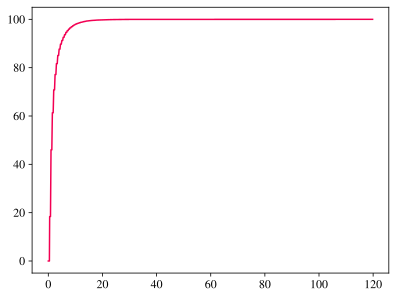

In [29]:
# per_colors = {per[0]: 'lightblue', per[1]: 'lightgreen'}

for intensity in lying_intensity_list:
    for method in methods:
        prev_ci_var = None
        prev_cdf_var = None

        for p in per:
            ci_var = globals()[f'{method}_CI_{intensity}_{p}']
            cdf_var = globals()[f'{method}_{intensity}_CDF_{p}']

            if intensity != base_intensity:
                linestyle = 'dashed'
            else:
                linestyle = 'solid'

            label = f'{method}' if intensity == base_intensity else None

            plt.plot(ci_var[:-1], cdf_var, label=label, color=color_scheme[method][p], linestyle=linestyle)  

            # # Fill the area between the current curve and the previous curve (if it exists)
            # if prev_ci_var is not None and prev_cdf_var is not None:
            #     plt.fill_betweenx(cdf_var, prev_ci_var[:-1], ci_var[:-1], color=per_colors[p], alpha=0.5)

            # prev_ci_var, prev_cdf_var = ci_var, cdf_var

plt.ylim([0, 100])
plt.xlim([0, 120])

# Add title and labels to the axes
plt.title('CDF of Interdetection Times')
plt.xlabel('Interdetection Time (s)')
plt.ylabel('CDF [\%]')
plt.plot([],[], '-', color='#333', label='$I_L=100$m')
plt.plot([],[], '--', color='#333', label='$I_L=200$m')
leg = plt.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')
# plt.legend(fancybox=False, framealpha=1.0)  # Display the legend

plt.grid(True)

plt.savefig(f"../figures/interdetection_times_{methods}_m{num_malicios}_per{per}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"../figures/interdetection_times_{methods}_m{num_malicios}_per{per}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()



KeyError: 0.1

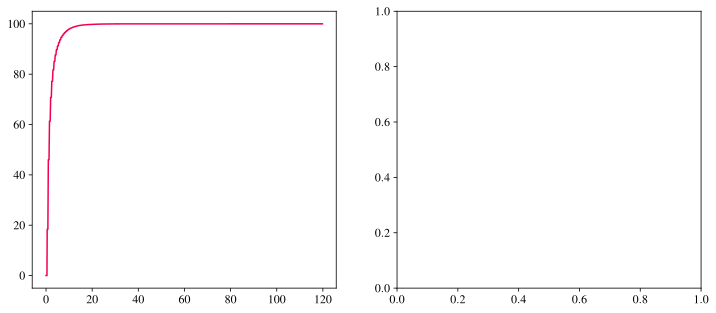

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Create a flag to check if the method label is already added to the legend
label_added = {'ART': False, 'MGT': False}

for intensity in lying_intensity_list:
    # Plot for methods ART and MGT
    for idx, method in enumerate(methods):
        prev_ci_var = None
        prev_cdf_var = None

        for p in per:
            ci_var = globals()[f'{method}_CI_{intensity}_{p}']
            cdf_var = globals()[f'{method}_{intensity}_CDF_{p}']

            linestyle = 'dashed' if intensity != base_intensity else 'solid'

            # Set label only if it hasn't been added yet
            label = method if not label_added[method] else None
            label_added[method] = True

            axes[0].plot(ci_var[:-1], cdf_var, label=label, color=color_scheme[method][p], linestyle=linestyle)
            prev_ci_var, prev_cdf_var = ci_var, cdf_var

        # Settings for the ART and MGT plot
        axes[0].set_ylim([0, 100])
        axes[0].set_xlim([0, 15])
        axes[0].set_title(f'CDF of Interdetection Times (ART, MGT,$N_M= {num_malicios}$, $p_\mathrm{{err}} = {per}$\%)')
        axes[0].set_xlabel('Interdetection Time (s)')
        axes[0].set_ylabel('CDF [\%]')
        axes[0].grid(True)

# Add legend entries for $I_L=100$m and $I_L=200$m
handles, labels = axes[0].get_legend_handles_labels()
handles += [plt.Line2D([0], [0], linestyle='-', color='#333', label='$I_L=100$m'),
            plt.Line2D([0], [0], linestyle='--', color='#333', label='$I_L=200$m')]
labels += ['$I_L=100$m', '$I_L=200$m']

leg = axes[0].legend(handles=handles, labels=labels, loc="lower right", fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

# Reset the flag for the next set of methods
label_added = {'PEPT': False, 'REPT': False}

for intensity in lying_intensity_list:
    # Plot for methods PEPT and REPT
    for idx, method in enumerate(methods2):
        prev_ci_var = None
        prev_cdf_var = None

        for p in per:
            ci_var = globals()[f'{method}_CI_{intensity}_{p}']
            cdf_var = globals()[f'{method}_{intensity}_CDF_{p}']

            linestyle = 'dashed' if intensity != base_intensity else 'solid'

            # Set label only if it hasn't been added yet
            label = method if not label_added[method] else None
            label_added[method] = True

            axes[1].plot(ci_var[:-1], cdf_var, label=label, color=color_scheme[method][p], linestyle=linestyle)
            prev_ci_var, prev_cdf_var = ci_var, cdf_var

        # Settings for the PEPT and REPT plot
        axes[1].set_ylim([0, 100])
        axes[1].set_xlim([0, 120])
        axes[1].set_title(f'CDF of Interdetection Times (PEPT, REPT,$N_M= {num_malicios}$, $p_\mathrm{{err}} = {per}$\%)')
        axes[1].set_xlabel('Interdetection Time (s)')
        axes[1].set_ylabel('CDF [\%]')
        axes[1].grid(True)

    # Add legend entries for $I_L=100$m and $I_L=200$m
    handles, labels = axes[1].get_legend_handles_labels()
    handles += [plt.Line2D([0], [0], linestyle='-', color='#333', label='$I_L=100$m'),
                plt.Line2D([0], [0], linestyle='--', color='#333', label='$I_L=200$m')]
    labels += ['$I_L=100$m', '$I_L=200$m']

    leg = axes[1].legend(handles=handles, labels=labels, loc="lower right", fancybox=False, framealpha=1.0)
    leg.get_frame().set_edgecolor('#333')

# Save the figure
fig.tight_layout()
fig.savefig(f"../figures/interdetection_times_combined_m{num_malicios}_per{per}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/interdetection_times_combined_m{num_malicios}_per{per}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()



In [ ]:
def get_detection_time(method, num_nodes, lying_intensity):
    detection_times = []
    detection:times =  []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'../res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']
            df = pl.read_csv(f'../res/v{v}/{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.csv')
            df = df.filter(pl.col("detected_node").is_in(malicious_nodes))
            # if method == "REPT":
            #     df = df.filter(pl.col("votes_is_malicious") > 1)
            times = df.groupby('detected_node').agg(pl.col('detected_at').min()).sort(pl.col('detected_at'))['detected_at'].to_numpy() - warmup_time
            detection_times.append(times)
        except:
            pass

    mean_detection_times = []
    detection_times_ci = []

    for i in range(num_nodes):
        samples = []
        for s in detection_times:
            try:
                samples.append(s[i])
            except:
                pass

        [m,h] = calculate_confidence_interval(samples)
        mean_detection_times.append(m)
        detection_times_ci.append(h)

    start = 0.005 #if method != 'REPT' and method != 'PEPT' else 0.5
    return (np.array([start] + mean_detection_times), np.array([0] + detection_times_ci))



In [ ]:
def get_overhead_data(method, num_nodes, lying_intensity):
    detection_times = []
    err_rate = 0
    # detection:times =  []
    bytes_sent = []
    bytes_sent_overhead = []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'../res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']

            bytes_sent.append(summary['bytes_sent'])
            bytes_sent_overhead.append(summary['bytes_sent_overhead'])
            # err_rate = calculate_confidence_interval(bytes_sent_overhead)

        except:
            pass

    err_rate = calculate_confidence_interval(bytes_sent_overhead)

    return np.mean(bytes_sent), np.mean(bytes_sent_overhead), err_rate

In [ ]:
def get_overhead_packet(method, num_nodes, lying_intensity):
    detection_times = []
    err_rate= 0
    packets_sent = []
    packets_sent_overhead = []
        # detection:times =  []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'../res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']

            packets_sent.append(summary['packets_sent'])
            packets_sent_overhead.append(summary['packets_sent_overhead'])
            err_rate = calculate_confidence_interval(packets_sent_overhead)

        except:
            pass

    err_rate = calculate_confidence_interval(packets_sent_overhead)
    

    return np.mean(packets_sent), np.mean(packets_sent_overhead), err_rate

In [ ]:
PEPT_50, PEPT_50_overhead, PEPT_50_data_err = get_overhead_data('PEPT', num_malicios, 50)
REPT_50, REPT_50_overhead, REPT_50_data_err = get_overhead_data('REPT', num_malicios, 50)
REPT_50_packet, REPT_50_overhead_packet, REPT_50_packet_err = get_overhead_packet('REPT', num_malicios, 50)

/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/fu/.pyenv/versions/3.9.14/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


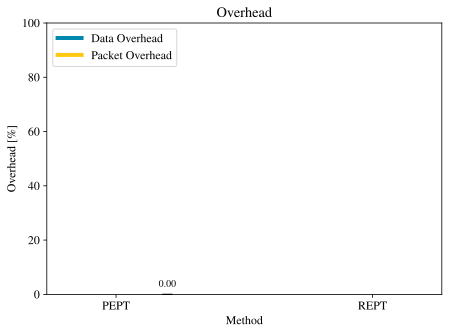

In [ ]:
DATA_OVERHEAD_COLOR = color_M2
PACKET_OVERHEAD_COLOR = color_C1

fig, ax = plt.subplots()

# Calculate the overhead percentages
PEPT_50_data_overhead_percentage = (PEPT_50_overhead / PEPT_50) * 100
REPT_50_data_overhead_percentage = (REPT_50_overhead / REPT_50) * 100
REPT_50_packet_overhead_percentage = (REPT_50_overhead_packet / REPT_50_packet) * 100

# Data for the bar plot
methods = ['PEPT', 'REPT']
colors = [DATA_OVERHEAD_COLOR, PACKET_OVERHEAD_COLOR]

# Adjusting the positions for bars
bar_width = 0.3
positions = [0, 0.4, 1, 1.4]  # Setting positions to place the packet bar next to its corresponding method

# Values for each overhead type and method
values = [PEPT_50_data_overhead_percentage, 0, REPT_50_data_overhead_percentage, REPT_50_packet_overhead_percentage]
errors = [(PEPT_50_data_err[1]/ PEPT_50) * 100, 0, (REPT_50_data_err[1]/ REPT_50) * 100, (REPT_50_packet_err[1]/ REPT_50_packet) * 100]
errors_np = np.array(errors)
yerr = np.array([errors_np, errors_np])



# Creating the bar plots
bars = ax.bar(positions, values, color=[colors[0], colors[1], colors[0], colors[1]], width=bar_width,yerr=errors, capsize= 5)

# Adjusting x-axis labels to show 'PEPT' and 'REPT' only
ax.set_xticks([0.2, 1.2])
ax.set_xticklabels(methods)

# Adding legend for type of overhead
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=DATA_OVERHEAD_COLOR, lw=4, label='Data Overhead'),
                   Line2D([0], [0], color=PACKET_OVERHEAD_COLOR, lw=4, label='Packet Overhead')]
ax.legend(handles=legend_elements)

# Set the Y-axis limit to 100%
ax.set_ylim(0, 100)

# Set labels and title
ax.set_ylabel('Overhead [\%]')
ax.set_xlabel('Method')
ax.set_title('Overhead')

# Display the actual percentage on top of each bar
for bar, value in zip(bars, values):
    ax.text(bar.get_x()  + bar.get_width() / 2, bar.get_height() + 2, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



In [ ]:
# pl.read_csv(f'../res/v001/PEPT_l500_m60_r0.csv').filter(pl.col("detected_node").is_in([0,5]))

In [ ]:
# fig, ax = plt.subplots()

# ax.plot(MGT_100)
# ax.plot(MGT_200)
# ax.plot(MGT_400)

# x,_ = get_detection_time('MGT', num_malicios, 5)
# ax.plot(x)

In [ ]:
# PEPT_CI_100

In [ ]:
# PEPT_CI_100 = PEPT_CI_100 /9